In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
import math
import numpy as np

## Quick revision of the Grover's algorithm

### Idea

Geometric interpretation of the states relevant to the algorithm from wikipedia.org

<img src="https://upload.wikimedia.org/wikipedia/commons/1/16/Grovers_algorithm_geometry.png" style="background-color:white;" />

For n qubits problem with $\omega$ as the solution, the followings are defined.

\begin{align*}
N &= 2^n                                                    \\

|\omega\rangle \; &\textrm{where} \; \omega \in \{0..N-1\}  \\

|s\rangle &= \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1} |x\rangle   \\

|s'\rangle &= \frac{1}{\sqrt{N-1}}\sum_{x\neq \omega, x=0}^{N-1} |x\rangle
\end{align*}

The goal is to move the state from $|s\rangle$ as close as to $|\omega\rangle$.  Then, the measured value is likely $\omega$.  

The algorithm is to start with $|s\rangle$ and flip it along $|s'\rangle$.  And then, flip along $|s\rangle$.  Iterate a number of times such that the resulting state is approximately $|\omega\rangle$.

### The operators

Grover's algorithm uses 2 operators: $\operatorname{U_\omega}$ and $\operatorname{U_s}$.

Consider the projection operator $|\omega\rangle \langle \omega |$.  For any state $|\phi\rangle$, 
$|\omega\rangle \langle \omega |\phi\rangle$ is the component along $|\omega\rangle$.  Therefore, $\operatorname{U_\omega}$ can be expressed as $ \operatorname{I} - 2 |\omega\rangle \langle\omega| $ (effectivley, multiple -1 to the component $|\omega\rangle$).

$ \operatorname{U_\omega} = \operatorname{I} - 2 |\omega\rangle \langle\omega| $

Consider the projection operator $|s\rangle \langle s|$.  For any state $|\phi\rangle$, 
$|s\rangle \langle s|\phi\rangle$ is the component along $|s\rangle$ and zero the component perpendicular to $|s\rangle$.  Therefore, $\operatorname{U_s}$ can be expressed as $ 2 |s \rangle \langle s| - \operatorname{I}$ (effectivley, multiple -1 to the component perpendicular to $|s\rangle$).

$\operatorname{U_s} = 2 |s \rangle \langle s| - \operatorname{I}$

After the first iteration, the resulting state becomes $\operatorname{U_sU_\omega} |s\rangle$.

### Number of iterations

\begin{align*}
\cos \frac{\theta}{2} &= \langle s'|s \rangle   \\
                      &= \sqrt \frac{N-1}{N}    \\
\end{align*}

Therefore,

\begin{align*}
\sin \frac{\theta}{2} &= \frac{1}{\sqrt{N}}     \\
\theta                &= \frac{2}{\sqrt{N}} \; \textrm{for large N, hence small} \; \theta    \\
\end{align*}

The number of iteration r is an integer such that,

\begin{align*}
r \theta &\approx \frac{\pi}{2}                 \\
r        &\approx \frac{\pi}{4} \sqrt{N} = \frac{\pi}{4} 2^\frac{n}{2} \approx 2^\frac{n}{2}
\end{align*}

If there are m matches out of N, say $\omega_0$ .. $\omega_{m-1}$, $|\omega \rangle$ is replaced by $|\psi\rangle = \frac{1}{\sqrt{m}} \sum_{i=0}^{m-1} |\omega_i \rangle$.

\begin{align*}
\cos \frac{\theta}{2} &= \langle s'|s \rangle   \\
                      &= \sqrt \frac{N-m}{N}    \\
\end{align*}

Therefore,

\begin{align*}
\sin \frac{\theta}{2} &= \sqrt{\frac{m}{N}}     \\
\theta                &= 2\sqrt{\frac{m}{N}} \; \textrm{for} \; m \ll N \textrm{, hence small} \; \theta    \\
\end{align*}

The number of iteration r is an integer such that,

\begin{align*}
r \theta &\approx \frac{\pi}{2}                 \\
r        &\approx \frac{\pi}{4} \sqrt{\frac{N}{m}} = \frac{\pi 2^\frac{n}{2}}{4 \sqrt{m}} 
                \approx \frac{2^\frac{n}{2}}{\sqrt{m}}
\end{align*}

### The circuits $\operatorname{U_\omega}$

Phase kickback can be used to negate the coefficient of a specific state component.  For example $\omega = 100$ (binary), $\operatorname{U_\omega}$ can be implemented as the circuit below.  Therefore, the implemented circuit has an extra qubits y for phase kickback.

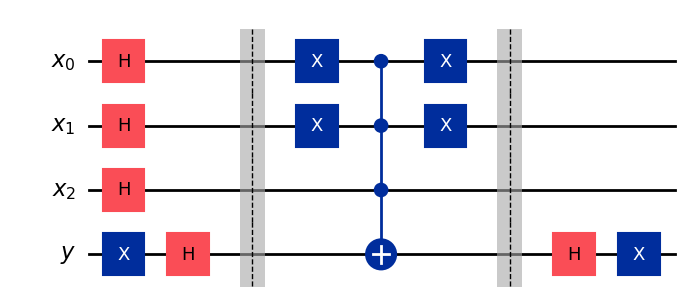

In [2]:
qreg1_x = QuantumRegister(3, 'x')
qreg1_y = QuantumRegister(1, 'y')
qc1 = QuantumCircuit(qreg1_x, qreg1_y)

# prepare |s>
qc1.h(qreg1_x)
# prepare |-> state for phase kickback
qc1.x(qreg1_y)
qc1.h(qreg1_y)

qc1.barrier()

# U_w, flip the coefficient sign of |100> by phase kickback
qc1.x(qreg1_x[0])
qc1.x(qreg1_x[1])
qc1.mcx(qreg1_x, qreg1_y)
qc1.x(qreg1_x[1])
qc1.x(qreg1_x[0])

qc1.barrier()

# restore y from |-> to |0> so that only the coefficients of |0xxx> are non-zeros
qc1.h(qreg1_y)
qc1.x(qreg1_y)

qc1.draw('mpl')

In [3]:
from qiskit.quantum_info import Statevector
sv1 = Statevector(qc1)
sv1.data

array([ 3.53553391e-01+0.j,  3.53553391e-01+0.j,  3.53553391e-01+0.j,
        3.53553391e-01+0.j, -3.53553391e-01+0.j,  3.53553391e-01+0.j,
        3.53553391e-01+0.j,  3.53553391e-01+0.j,  3.36731597e-18+0.j,
        3.36731597e-18+0.j,  3.36731597e-18+0.j,  3.36731597e-18+0.j,
       -3.36731597e-18+0.j,  3.36731597e-18+0.j,  3.36731597e-18+0.j,
        3.36731597e-18+0.j])

In [4]:
firstline = True
for i, amp in enumerate(sv1.data):
    if np.absolute(amp.real) > 1e-10:
        if not firstline:
            print("+ ", end="")
        print(f"{amp:.4f} |{i:04b}>")
        firstline = False

0.3536+0.0000j |0000>
+ 0.3536+0.0000j |0001>
+ 0.3536+0.0000j |0010>
+ 0.3536+0.0000j |0011>
+ -0.3536+0.0000j |0100>
+ 0.3536+0.0000j |0101>
+ 0.3536+0.0000j |0110>
+ 0.3536+0.0000j |0111>


Note that the coefficients of $|0xxx\rangle$ are $\frac{1}{\sqrt{8}}$, except $-\frac{1}{\sqrt{8}}|0100\rangle$.  The rest coefficients of $|1xxx\rangle$ are all zeros ($10^{-18}$).

### The circuits $\operatorname{U_s}$

\begin{align*}
\operatorname{U_s} &= 2 |s\rangle \langle s| - \operatorname{I}         \\
&= \operatorname{H^{\otimes n}} (2 |0\rangle \langle 0| - \operatorname{I}) \operatorname{H^{\otimes n}} \\

\end{align*}

The part between $\operatorname{H}^{\otimes n}$ can be implemented as $\operatorname{U_\omega}$ with $\omega=0$ because the global phase -1 does not affect the measured result.

The overall operation (before measure) is,

\begin{align*}
(\operatorname{U_s}\operatorname{U_\omega})^r \operatorname{H^{\otimes n}} |0..0\rangle
\end{align*}

where the n qubits are initialized as 0.  In the actual circuit, there is an additional qubit for phase kickback.

## Example: [Boolean Satisfiability Problem](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem)

Apply Grover's algorithm to find $(x_0, x_1, x_2)$ such that the expression return true.

$ (x_0 \lor \neg x_1) \land (\neg x_0 \lor x_1 \lor x_2) \land \neg x_2 \land (x_0 \lor x_1) $

$ = \neg (\neg x_0 \land x_1) \land \neg (x_0 \land \neg x_1 \land \neg x_2) \land \neg x_2 \land \neg (\neg x_0 \land \neg x_1) $

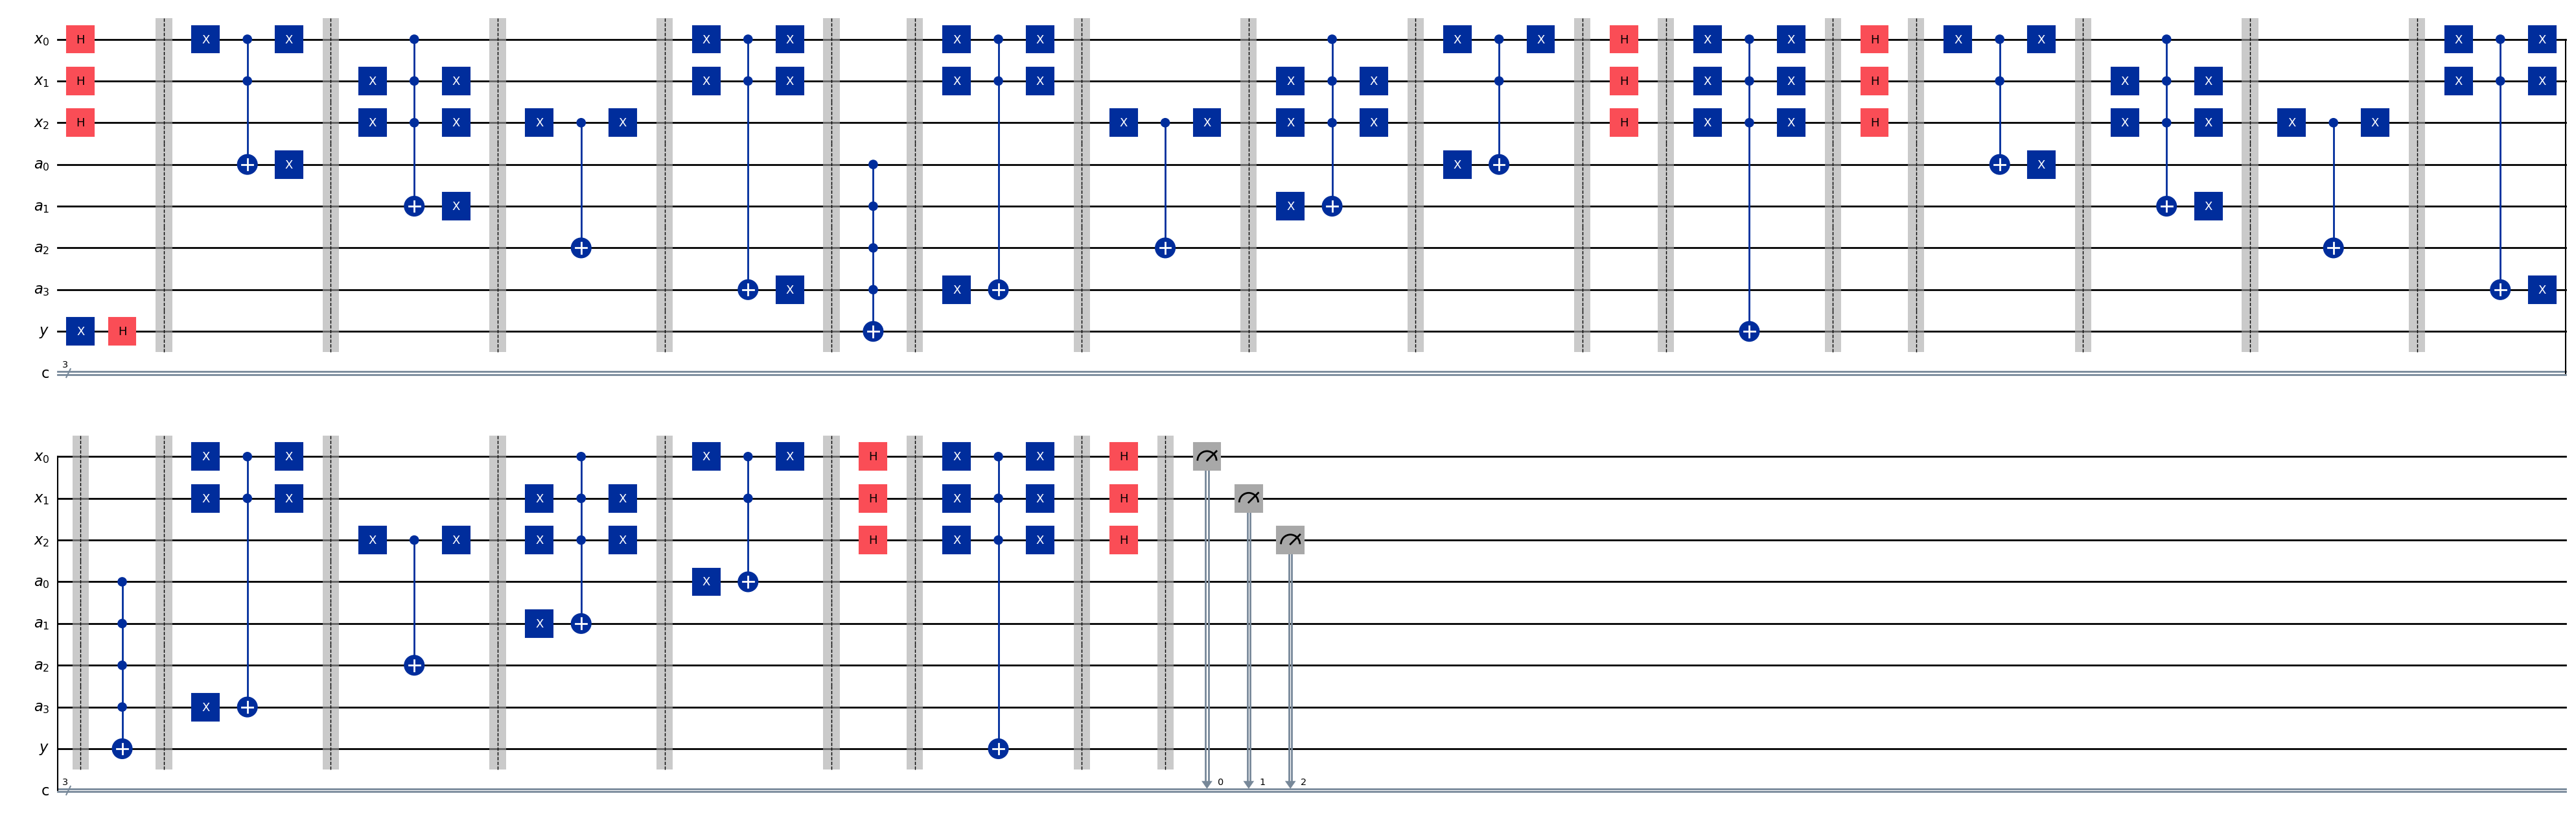

In [5]:
qreg2_x = QuantumRegister(3, 'x')
qreg2_a = QuantumRegister(4, 'a')
qreg2_y = QuantumRegister(1, 'y')
creg2 = ClassicalRegister(3, name='c')
qc2 = QuantumCircuit(qreg2_x, qreg2_a, qreg2_y, creg2)

def append_U_w(qc):
    # Oracle

    # a_0 = !(!x_0 & x_1)
    # then, restore x_0 to original value
    qc.x(qreg2_x[0])
    qc.ccx(qreg2_x[0], qreg2_x[1], qreg2_a[0])
    qc.x(qreg2_a[0])
    qc.x(qreg2_x[0])
    qc.barrier()

    # a_1 = !(x_0 & !x_1 & !x_2)
    qc.x(qreg2_x[1])
    qc.x(qreg2_x[2])
    qc.mcx(qreg2_x, qreg2_a[1])
    qc.x(qreg2_a[1])
    qc.x(qreg2_x[2])
    qc.x(qreg2_x[1])
    qc.barrier()

    # a_2 = !x_2
    qc.x(qreg2_x[2])
    qc.cx(qreg2_x[2], qreg2_a[2])
    qc.x(qreg2_x[2])
    qc.barrier()

    # a_3 = !(!x_0 & !x_1)
    qc.x(qreg2_x[0])
    qc.x(qreg2_x[1])
    qc.ccx(qreg2_x[0], qreg2_x[1], qreg2_a[3])
    qc.x(qreg2_a[3])
    qc.x(qreg2_x[1])
    qc.x(qreg2_x[0])
    qc.barrier()

    # phase kickback
    qc.mcx(qreg2_a, qreg2_y)
    qc.barrier()

    # restore a_0 to a_3
    qc.x(qreg2_x[0])
    qc.x(qreg2_x[1])
    qc.x(qreg2_a[3])
    qc.ccx(qreg2_x[0], qreg2_x[1], qreg2_a[3])
    qc.x(qreg2_x[1])
    qc.x(qreg2_x[0])
    qc.barrier()

    qc.x(qreg2_x[2])
    qc.cx(qreg2_x[2], qreg2_a[2])
    qc.x(qreg2_x[2])
    qc.barrier()

    qc.x(qreg2_x[1])
    qc.x(qreg2_x[2])
    qc.x(qreg2_a[1])
    qc.mcx(qreg2_x, qreg2_a[1])
    qc.x(qreg2_x[2])
    qc.x(qreg2_x[1])
    qc.barrier()

    qc.x(qreg2_x[0])
    qc.x(qreg2_a[0])
    qc.ccx(qreg2_x[0], qreg2_x[1], qreg2_a[0])
    qc.x(qreg2_x[0])
    qc.barrier()

def append_U_s(qc):
# Amplification
    qc.h(qreg2_x)
    qc.barrier()

    qc.x(qreg2_x)
    qc.mcx(qreg2_x, qreg2_y)
    qc.x(qreg2_x)
    qc.barrier()

    qc.h(qreg2_x)
    qc.barrier()

# prepare |s> 
qc2.h(qreg2_x)

# prepare |-> state for phase kickback
qc2.x(qreg2_y)
qc2.h(qreg2_y)
qc2.barrier()

# iterate 2 times for 3 qubits (~sqrt(2^3))
append_U_w(qc2)
append_U_s(qc2)
append_U_w(qc2)
append_U_s(qc2)

qc2.measure(qreg2_x, creg2)
qc2.draw('mpl', fold=60)

In [6]:
sampler = StatevectorSampler()
job = sampler.run([qc2])
result = job.result()[0]
samp_dist = result.data.c.get_counts()
print(samp_dist)

{'011': 976, '100': 9, '001': 9, '010': 8, '000': 6, '111': 8, '101': 7, '110': 1}


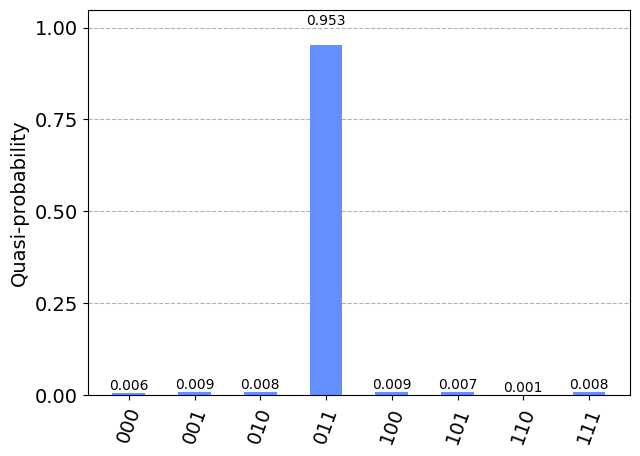

In [7]:
plot_distribution(samp_dist)

Solution is $(x_0, x_1, x_2) = (1, 1, 0)$.  Note that qiskit convention is $|x_2 x_1 x_0 \rangle$.

In [8]:
qiskit.__version__

'1.0.2'